# Assignment 6

### a)

In [1]:
import statsmodels.api as sm

In [1]:
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import scipy.stats as ss
from datetime import datetime
from scipy import stats
from scipy.stats import t
#goqhuB-1hafqe-dojvix
import wrds
db = wrds.Connection(wrds_username = 'anita97') 

WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
There was an error with your password.


OperationalError: (psycopg2.OperationalError) could not translate host name "wrds-pgdata.wharton.upenn.edu" to address: Unknown host

(Background on this error at: http://sqlalche.me/e/e3q8)

In [3]:
#import stocks
stocks = db.raw_sql("select a.permno, a.date, b.exchcd, a.ret, a.shrout, b.shrcd, a.prc \
                  from crsp.msf as a \
                  join crsp.msenames as b \
                  on a.permno = b.permno and b.namedt <= a.date \
                  where b.shrcd between (10) and (11)and a.date >='1970-01-01' and a.date<='2018-12-31'\
                  and b.exchcd between 1 and 2")


In [4]:
# drop NA and shares with less than 24 observations 
stocks = stocks.set_index('permno')
x = stocks.groupby('permno').count()['ret'][lambda x: x>23]
selected_stocks=list(x.index)
stocks=stocks.loc[selected_stocks]
stocks=stocks.dropna()
stocks['prc'] = abs(stocks['prc'])
stocks_copy = stocks.copy()

In [5]:
# import risk free rate
RF = db.raw_sql("select mcaldt as date, tmytm as rf from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='1970-01-01' and mcaldt<='2018-12-31'")
Rf_monthly = np.exp(np.divide(RF.rf, 1200)) -1
Rf = pd.DataFrame([RF.date, Rf_monthly], index=['date', 'rf']).T

In [6]:
# import rm 
Rm = db.raw_sql("select date, vwretd from crsp.msi where date>='1970-01-01' and date<='2018-12-31'")
Rm = pd.DataFrame([Rm.date, Rm.vwretd.values], index=['date', 'mkt_ret']).T
Rm = Rm.set_index('date')

### b)

In [7]:
beta_series=[]
for i in selected_stocks:
    current_stock=stocks.loc[i]
    cov=np.cov((current_stock.ret.astype(float)), (Rm.loc[current_stock.date].mkt_ret.astype(float)))
    beta_series.append(cov[0,1]/cov[1,1])

In [8]:
beta = pd.DataFrame(beta_series, index=selected_stocks, columns=["val"])
pd_decile = pd.DataFrame(pd.qcut(beta.val,10),index=selected_stocks, columns=["val"])

In [9]:
beta.head()

,val
10001.0,0.038828
10006.0,1.055701
10014.0,1.291379
10028.0,0.855114
10029.0,0.208451


In [10]:
inters = pd.qcut(beta.val,10).values
inters = list(dict.fromkeys(inters))
inters.sort()

In [11]:
pd_decile.sort_values(by="val")
pd_decile.reset_index(inplace=True)
group_by_decile = pd_decile.groupby("val")

In [12]:
#Plot :
def plot(beta,ret,rf,rm,titler):
    slope, intercept, r_value, p_value, std_err = stats.linregress(beta,ret)
    plt.figure(figsize=(10,6))
    plt.plot(beta, ret, 'ro', label='Portfolios')
    plt.plot(np.linspace(0,2.5,100), rf + np.linspace(0,2.5,100)*(rm - rf), label='CAPM')
    plt.plot(np.linspace(0,2.5,100),np.linspace(0,2.5,100)*slope+intercept,label = 'Linear Regression')
    plt.title(title)
    plt.xlabel('Average beta')
    plt.ylabel('Average return')
    plt.grid()
    plt.legend(loc='best')
    plt.show()
    print('Slope coefficient :',slope)
    print('Intercept coefficient :',intercept)

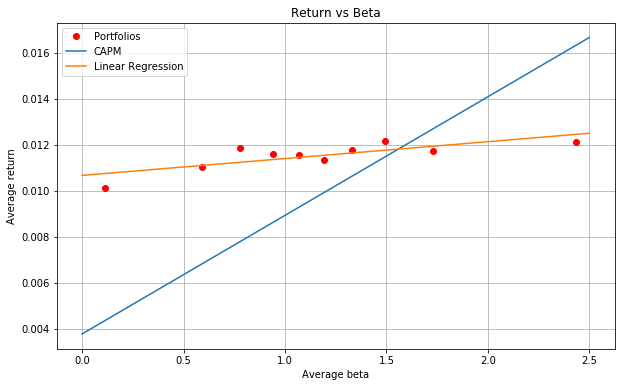

Slope coefficient : 0.0007330684469002539
Intercept coefficient : 0.010663450570134157


In [13]:
avg_returns = []
avg_beta = []
for i in inters:
    stock_index_by_inderval = group_by_decile.get_group(i)["index"]
    temp = stocks.loc[stock_index_by_inderval]
    group_by_date = temp.groupby('date').mean()
    comp = group_by_date.ret
    avg_returns.append(comp.mean())
    avg_beta.append(beta.loc[stock_index_by_inderval].mean())

#variables 
avg_ret_m = Rm.mkt_ret.mean()
avg_rf    = Rf.rf.mean()
title = 'Return vs Beta'
avg_beta = [avg_beta[i][0] for i in range(len(avg_beta))]
plot(avg_beta,avg_returns,avg_rf,avg_ret_m,title)

### c)

In [14]:
idx_L = group_by_decile.get_group(inters[0])["index"]
idx_H = group_by_decile.get_group(inters[-1])["index"]

stock_low_beta = stocks.loc[idx_L]
stock_high_beta = stocks.loc[idx_H]

group_by_date_low = stock_low_beta.groupby('date').mean()
group_by_date_high = stock_high_beta.groupby('date').mean()

simple_return = group_by_date_high.ret - group_by_date_low.ret

average = simple_return.mean()
standard_deviation = simple_return.std()

print('Average return : ',average)
print('Standar deviation : ',standard_deviation)

Average return :  0.0020075927397461913
Standar deviation :  0.09786798036285017


In [15]:
t_stat = (np.sqrt((len(simple_return)-1)) * average) / standard_deviation
def t_test(t_stat):
    alpha = 0.05
    t_tabel = t.ppf(1 - alpha/2, len(simple_return) - 1)
    if np.abs(t_stat)>t_tabel:
        print("We reject H0, t-stat :",t_stat)
    else:
        print("We can't reject H0 and the mean return is not statiscally different from 0, t-stat :",t_stat)

In [16]:
t_test(t_stat)

We can't reject H0 and the mean return is not statiscally different from 0, t-stat : 0.4969973131749323


### d)

In [17]:
stocks.insert(5, 'mkt_cap', stocks.prc * stocks.shrout)
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [18]:
stocks.insert(7,'mrk_cap_lag',stocks.groupby('permno')['mkt_cap'].shift(1))
stocks_wavg = stocks.groupby('permno').mean()
stocks_wavg.insert(6,'beta',beta)

In [19]:
w_avg_returns = []
w_avg_beta = []
for i in inters:
    stock_index_by_inderval = group_by_decile.get_group(i)["index"]
    wtemp = stocks.loc[stock_index_by_inderval]
    wgroup_by_date = wtemp.groupby('date').apply(wavg, 'ret', 'mrk_cap_lag')
    w_avg_returns.append(wgroup_by_date.mean())
    w_avg_beta.append(stocks_wavg.beta.loc[stock_index_by_inderval].mean())

In [20]:
wtemp.head()

,date,exchcd,ret,shrout,shrcd,mkt_cap,prc,mrk_cap_lag
permno,,,,,,,,
10066.0,1999-04-30,2.0,0.000000,24699.0,11.0,72553.3125,2.9375,NaN
10066.0,1999-05-28,2.0,-0.148936,25423.0,11.0,63557.5000,2.5000,72553.3125
10066.0,1999-06-30,2.0,0.050000,25207.0,11.0,66168.3750,2.6250,63557.5000
10066.0,1999-07-30,2.0,-0.190476,25207.0,11.0,53564.8750,2.1250,66168.3750
10066.0,1999-08-31,2.0,-0.323529,25207.0,11.0,36235.0625,1.4375,53564.8750


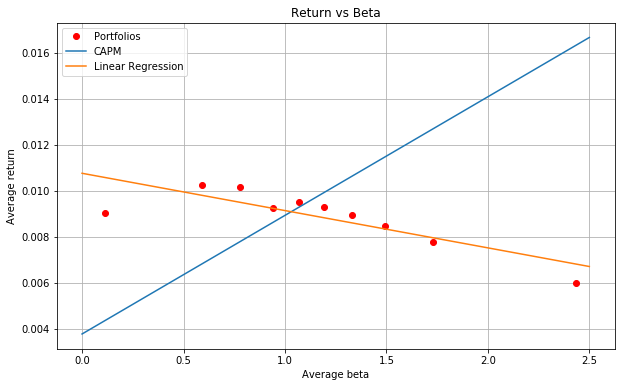

Slope coefficient : -0.0016223147191898996
Intercept coefficient : 0.010755169655474541


In [21]:
#variables 
title = 'Return vs Beta'
plot(w_avg_beta,w_avg_returns,avg_rf,avg_ret_m,title)

In [22]:
w_stock_low_beta = stocks.loc[idx_L].groupby('date').apply(wavg,'ret','mrk_cap_lag')
w_stock_high_beta = stocks.loc[idx_H].groupby('date').apply(wavg,'ret','mrk_cap_lag')

w_group_by_date_low = w_stock_low_beta.groupby('date').mean()
w_group_by_date_high = w_stock_high_beta.groupby('date').mean()

w_simple_return = w_group_by_date_high - w_group_by_date_low
w_average = w_simple_return.mean()
w_standard_deviation = w_simple_return.std()

print('Average weighted return : ',w_average)
print('Standard deviation weighted return : ',w_standard_deviation)

Average weighted return :  -0.003075309148491093
Standard deviation weighted return :  0.07981568753132572


In [23]:
w_t_stat = (np.sqrt((len(w_simple_return)-1)) * w_average) / w_standard_deviation
t_test(w_t_stat)

We can't reject H0 and the mean return is not statiscally different from 0, t-stat : -0.9335112837244361


### e)

In [24]:
Rm.head(3)

,mkt_ret
date,
1970-01-30,-0.0732544
1970-02-27,0.0567059
1970-03-31,-0.00472923


In [25]:
copy_Rm = Rm.copy()
copy_Rm.reset_index(inplace = True)
copy_stocks = stocks_copy.copy()
copy_stocks.reset_index(inplace = True)
copy_stocks.head(3)
copy_stocks = pd.merge(copy_stocks,copy_Rm,on = 'date')
copy_stocks.sort_values(['permno','date'],inplace = True)
copy_stocks = copy_stocks.set_index(['date','permno'])
copy_stocks.drop_duplicates(inplace = True)

In [26]:
cov_rolling = copy_stocks.groupby('permno')['ret','mkt_ret'].rolling(24).cov()
cov_rolling.dropna(inplace = True)

In [27]:
#cov_rolling.drop(['ret'],axis =1)
cov_rolling.drop('ret',level = 3,axis = 0, inplace = True)
cov_rolling['beta'] = cov_rolling['ret']/cov_rolling['mkt_ret']
cov_rolling.head(5)

ret   mkt_ret      beta
permno  date       permno                                       
10001.0 2011-11-30 10001.0 mkt_ret  0.001360  0.002754  0.494087
        2011-12-30 10001.0 mkt_ret  0.001220  0.002737  0.445952
        2012-01-31 10001.0 mkt_ret  0.001104  0.002728  0.404847
        2012-02-29 10001.0 mkt_ret  0.001109  0.002743  0.404226
        2012-03-30 10001.0 mkt_ret  0.001108  0.002630  0.421249

In [28]:
cov_rolling.reset_index(level = [0,3],drop = True,inplace = True)

In [29]:
cov_rolling.drop(['ret','mkt_ret'],axis = 1,inplace = True)

In [30]:
cov_rolling.drop_duplicates(inplace = True)
cov_rolling.head(5)

,,beta
date,permno,
2011-11-30,10001.0,0.494087
2011-12-30,10001.0,0.445952
2012-01-31,10001.0,0.404847
2012-02-29,10001.0,0.404226
2012-03-30,10001.0,0.421249


In [31]:
def merge_multi(self, df, on):
    return self.reset_index().join(df,on=on).set_index(self.index.names)

In [32]:
df_roll = merge_multi(cov_rolling,copy_stocks,on = ['date','permno'])
df_roll.drop(['exchcd','shrout','shrcd','prc','mkt_ret'],axis = 1,inplace = True)
df_roll.head()

,,beta,ret
date,permno,,
2011-11-30,10001.0,0.494087,-0.005000
2011-12-30,10001.0,0.445952,0.051835
2012-01-31,10001.0,0.404847,-0.019702
2012-02-29,10001.0,0.404226,0.005005
2012-03-30,10001.0,0.421249,0.048760


In [33]:
df_roll['quantile'] =df_roll.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=range(1,11)))

In [34]:
df_roll.head()

,,beta,ret,quantile
date,permno,,,
2011-11-30,10001.0,0.494087,-0.005000,2.0
2011-12-30,10001.0,0.445952,0.051835,2.0
2012-01-31,10001.0,0.404847,-0.019702,1.0
2012-02-29,10001.0,0.404226,0.005005,2.0
2012-03-30,10001.0,0.421249,0.048760,2.0


In [35]:
roll_point = df_roll.groupby('quantile').mean()

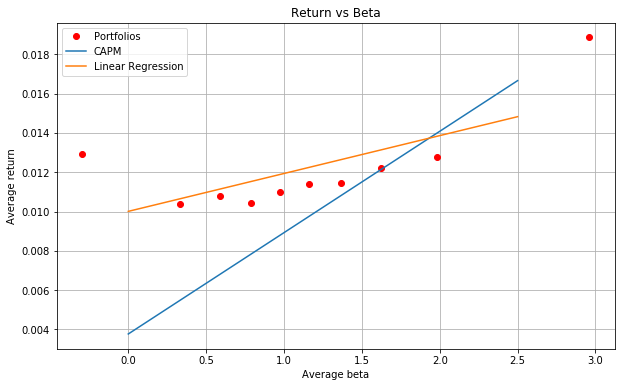

Slope coefficient : 0.0019285172285490096
Intercept coefficient : 0.010007175136582579


In [36]:
beta_roll = list(roll_point['beta'])
avg_ret = list(roll_point['ret'])
#variables 
title = 'Return vs Beta'
plot(beta_roll,avg_ret,avg_rf,avg_ret_m,title)

In [37]:
r_average = df_roll['ret'].mean()
r_standard_deviation = df_roll['ret'].std()

print('Average weighted return : ',r_average)
print('Standard deviation weighted return : ',r_standard_deviation)

Average weighted return :  0.012222112567599674
Standard deviation weighted return :  0.1445154326127728


In [38]:
r_t_stat = (np.sqrt((len(df_roll['ret'])-1)) * r_average) / r_standard_deviation
t_test(r_t_stat)

We reject H0, t-stat : 104.36778392764062


### f)

As we saw in the course, the Fama-McBeth approach consists in running cross sectional regression of the returns on 1 characteristic. This regression is performed on every period.
 The goal of this regression is to find the factor returns. Then, we should go long in the portfolio with the biggest factor return and short in the portfolio with the lowest factor return if it is positive. Otherwise go long the portfolio with the lowest factor return and short the portfolio with the highest factor return. 
In our case, the factor tested is the stock beta. To implement the Fama-McBeth approach in our case, we should care about the sign of the factor returns. In the previous graph, we observed that the returns decrease as stock’s beta increases. In this case, we should go long the lowest beta’s decile portfolio and short the biggest beta’s decile portfolio.

### g)

In [39]:
df2_stocks = stocks.copy()
df2_stocks.head()

,date,exchcd,ret,shrout,shrcd,mkt_cap,prc,mrk_cap_lag
permno,,,,,,,,
10001.0,2009-12-31,2.0,0.162621,4361.0,11.0,44918.300832,10.3000,NaN
10001.0,2010-01-29,2.0,-0.018932,4361.0,11.0,43871.661830,10.0600,44918.300832
10001.0,2010-02-26,2.0,-0.000656,4361.0,11.0,43646.632240,10.0084,43871.661830
10001.0,2010-03-31,2.0,0.020643,4361.0,11.0,44351.370333,10.1700,43646.632240
10001.0,2010-04-30,2.0,0.124385,6070.0,11.0,69137.302084,11.3900,44351.370333


In [40]:
df2_stocks['quantile'] =df2_stocks.groupby('date')['mrk_cap_lag'].transform(lambda x: pd.qcut(x, 10, labels=range(1,11)))
df2_stocks.dropna(inplace = True)
#df2_stocks.drop(['exchcd','shrout','shrcd','prc','mkt_cap','mrk_cap_lag'],axis = 1,inplace = True)
df2_stocks = pd.merge(df2_stocks,Rf,on = 'date')
df2_stocks.drop(['exchcd','shrout','shrcd','prc','mkt_cap','mrk_cap_lag','date'],axis = 1,inplace = True)
df2_stocks.drop_duplicates(inplace = True)
df2_stocks.dropna(inplace = True)
df2_stocks.head()

,ret,quantile,rf
0,-0.018932,2.0,1.26738e-05
1,-0.028369,1.0,1.26738e-05
6,0.175705,4.0,1.26738e-05
10,-0.075472,1.0,1.26738e-05
14,-0.056285,3.0,1.26738e-05


In [41]:
rf_list =[]
for i in range(1,11):
    rf_list+=[df2_stocks.loc[df2_stocks['quantile']==i]['rf'].mean()]
print(rf_list)

[0.003687249328037806, 0.0037681500531303543, 0.0038445146474203142, 0.003835816606531127, 0.0038420549875443676, 0.0038510680441779417, 0.003870875485959974, 0.003911906861251097, 0.00387544904616821, 0.003950775183339993]


In [42]:
rf_list = np.array(rf_list)
roll_point2 = df2_stocks.groupby('quantile')['ret'].mean()
std2 = df2_stocks.groupby('quantile').std()
re_list1 = np.array(roll_point2)
std_list1 = np.array(std2['ret'])
sharp_list = (re_list1 - rf_list)/std_list1

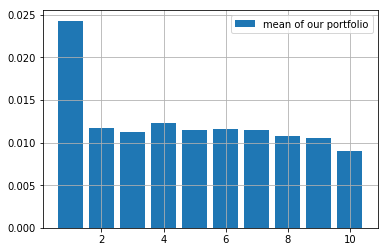

In [43]:
plt.bar(range(1,11),re_list1, width=0.8,label = 'mean of our portfolio')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.grid()
plt.legend(loc='best')
plt.show()

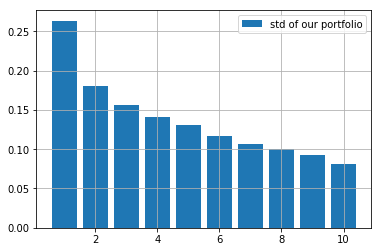

In [44]:
plt.bar(range(1,11),std_list1,width=0.8,label = 'std of our portfolio')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.grid()
plt.legend(loc='best')
plt.show()

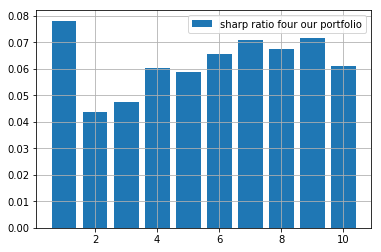

In [45]:
plt.bar(range(1,11),sharp_list,width=0.8,label = 'sharp ratio four our portfolio')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.grid()
plt.legend(loc='best')
plt.show()

In [46]:
stocks_mkt = stocks.copy()
stocks_mkt['mrk_cap_lag'] = np.where(stocks_mkt['mrk_cap_lag'].isna(), stocks_mkt['mrk_cap_lag']/(1+stocks_mkt['ret']),stocks_mkt['mrk_cap_lag'])
stocks_mkt['dec'] = stocks_mkt.groupby('date')['mrk_cap_lag'].transform(lambda x: pd.qcut(x,10,labels=False))

In [47]:
portfolio = pd.DataFrame(stocks_mkt.groupby(['date','dec']).ret.mean())
portfolio_returns = portfolio.groupby('dec').ret.mean()
portfolio_std = portfolio.groupby('dec').ret.std()
portfolio_sharpe_ratio = (portfolio_returns - avg_rf)/portfolio_std

In [48]:
alpha = 0.05
portfolio.reset_index(inplace=True)
portfolio.set_index('date',inplace=True)
high_stocks = portfolio.loc[portfolio.dec==np.max(stocks_mkt.dec)]
low_stocks = portfolio.loc[portfolio.dec==np.min(stocks_mkt.dec)]
SMB = low_stocks.ret - high_stocks.ret
SMB_avg = SMB.mean()
SMB_std = SMB.std()
print('SMB Average return: ',round(SMB_avg,4))
print('SMB Return Standard Deviation: ',round(SMB_std,4))


t_SMB_stat = np.sqrt(len(low_stocks)-1) * SMB_avg / SMB_std
t_tabel_SMB = t.ppf(1 - alpha/2, len(low_stocks) - 1)    

if np.abs(t_SMB_stat) > t_tabel_SMB:
    print("We reject H0, t-stat : ",t_tabel_SMB)
else:
    print("We can't reject H0 and the mean return is not statiscally different from 0")

SMB Average return:  0.0088
SMB Return Standard Deviation:  0.072
We reject H0, t-stat :  1.9640135365006253


### h)

In [49]:
dfh_stocks = stocks.copy()
#dfh_stocks['w_ret'] = dfh_stocks.groupby(['date','quantile']).apply(wavg, 'ret', 'mrk_cap_lag')
dfh_stocks.head()

,date,exchcd,ret,shrout,shrcd,mkt_cap,prc,mrk_cap_lag
permno,,,,,,,,
10001.0,2009-12-31,2.0,0.162621,4361.0,11.0,44918.300832,10.3000,NaN
10001.0,2010-01-29,2.0,-0.018932,4361.0,11.0,43871.661830,10.0600,44918.300832
10001.0,2010-02-26,2.0,-0.000656,4361.0,11.0,43646.632240,10.0084,43871.661830
10001.0,2010-03-31,2.0,0.020643,4361.0,11.0,44351.370333,10.1700,43646.632240
10001.0,2010-04-30,2.0,0.124385,6070.0,11.0,69137.302084,11.3900,44351.370333


In [50]:
dfh_stocks['quantile'] =dfh_stocks.groupby('date')['mrk_cap_lag'].transform(lambda x: pd.qcut(x, 10, labels=range(1,11)))
dfh_stocks.dropna(inplace = True)
Rm_copy = Rm.copy()
Rm_copy.reset_index(inplace = True)
dfh_stocks = pd.merge(dfh_stocks,Rf,on = 'date')
dfh_stocks = pd.merge(dfh_stocks,Rm_copy,on = 'date')
dfh_stocks.drop_duplicates(inplace = True)
dfh_stocks.dropna(inplace = True)
dfh_stocks.head()

,date,exchcd,ret,shrout,shrcd,mkt_cap,prc,mrk_cap_lag,quantile,rf,mkt_ret
0,2010-01-29,2.0,-0.018932,4361.0,11.0,43871.661830,10.06,44918.300832,2.0,1.26738e-05,-0.0370975
1,2010-01-29,2.0,-0.028369,9834.0,11.0,13472.580047,1.37,13865.939672,1.0,1.26738e-05,-0.0370975
6,2010-01-29,2.0,0.175705,31680.0,11.0,515116.807251,16.26,438134.397583,4.0,1.26738e-05,-0.0370975
7,2010-01-29,1.0,0.175705,31680.0,11.0,515116.807251,16.26,438134.397583,4.0,1.26738e-05,-0.0370975
10,2010-01-29,1.0,-0.075472,13352.0,11.0,19627.440382,1.47,21229.680446,1.0,1.26738e-05,-0.0370975


In [51]:
dfh_stocks['re_rf'] = dfh_stocks.ret - dfh_stocks.rf
#dfh_stocks['w_re_rf'] = dfh_stocks.ret - dfh_stocks.rf
dfh_stocks['rm_rf'] = dfh_stocks.mkt_ret - dfh_stocks.rf
dfh_stocks.drop(['exchcd','shrout','shrcd','prc','mkt_cap','mrk_cap_lag','date','rf','mkt_ret'],axis = 1,inplace = True)
dfh_stocks.head()

,ret,quantile,re_rf,rm_rf
0,-0.018932,2.0,-0.0189447,-0.0371102
1,-0.028369,1.0,-0.0283814,-0.0371102
6,0.175705,4.0,0.175692,-0.0371102
7,0.175705,4.0,0.175692,-0.0371102
10,-0.075472,1.0,-0.0754844,-0.0371102


In [52]:
list_beta_p =[]
#list_beta_p_w =[]
for i in range(1,11):
    y = list(dfh_stocks.loc[dfh_stocks['quantile']==i]['re_rf'])
    #y_w = list(dfh_stocks.loc[dfh_stocks['quantile']==i]['w_re_rf'])
    x = list(dfh_stocks.loc[dfh_stocks['quantile']==i]['rm_rf'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    #slope_w, intercept_w, r_value_w, p_value_w, std_err_w = stats.linregress(x,y_w)
    list_beta_p +=[slope]
    #list_beta_p_w +=[slope_w]
print(list_beta_p)

[1.1153244485640064, 1.1420170163192465, 1.1674089563501846, 1.2007452280854778, 1.1948747639085777, 1.133956403054619, 1.0842847053094453, 1.0641467278786048, 0.9970304727466615, 0.93718769426042]


In [53]:
ret_2 = list(dfh_stocks.groupby('quantile').mean()['ret'])
#ret_2_w = list(dfh_stocks.groupby('quantile').mean()['w_ret'])

In [54]:
def plot1(beta,ret,rf,rm,titler):
    slope, intercept, r_value, p_value, std_err = stats.linregress(beta,ret)
    plt.figure(figsize=(10,6))
    plt.plot(beta, ret, 'ro', label='Portfolios')
    plt.plot(np.linspace(0.8,1.3,100), rf + np.linspace(0.8,1.3,100)*(rm - rf), label='CAPM')
    plt.plot(np.linspace(0.8,1.3,100),np.linspace(0.8,1.3,100)*slope+intercept,label = 'Linear Regression')
    plt.title(title)
    plt.xlabel('Average beta')
    plt.ylabel('Average return')
    plt.grid()
    plt.legend(loc='best')
    plt.show()
    print('Slope coefficient :',slope)
    print('Intercept coefficient :',intercept)

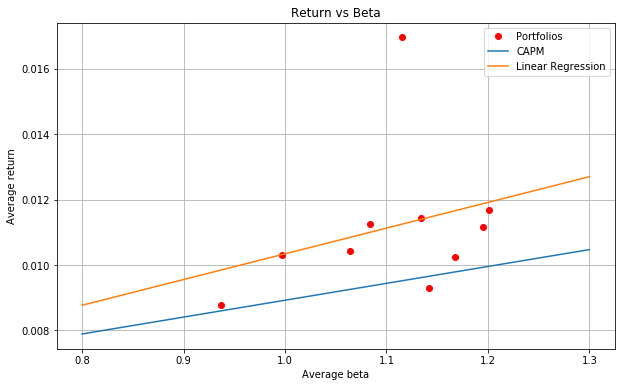

Slope coefficient : 0.007862161361553332
Intercept coefficient : 0.0024802908574804976


In [55]:
title = 'Return vs Beta'
plot1(list_beta_p,ret_2,avg_rf,avg_ret_m,title)

In [56]:
dfh2_stocks = stocks.copy()
dfh2_stocks['quantile'] =dfh2_stocks.groupby('date')['mrk_cap_lag'].transform(lambda x: pd.qcut(x, 10, labels=range(1,11)))
dfh2_stocks.dropna(inplace = True)
value_weighted_portfolio = pd.DataFrame([dfh2_stocks.groupby(['date','quantile']).apply(wavg,'ret','mrk_cap_lag')]).T

In [57]:
Rf.set_index('date',inplace=True)

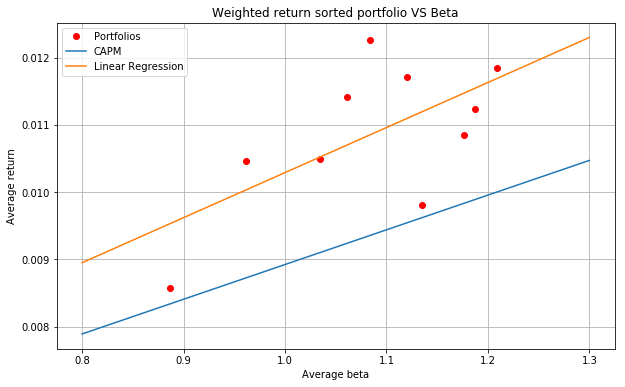

Slope coefficient : 0.0066961827741601684
Intercept coefficient : 0.003594435407031385


In [58]:
# value-weighted returns
value_weighted_portfolio = pd.DataFrame([stocks_mkt.groupby(['date','dec']).apply(wavg,'ret','mrk_cap_lag')]).T
value_weighted_portfolio.columns = (['ret'])
value_weighted_portfolio.reset_index(inplace=True)
value_weighted_portfolio.set_index('date',inplace=True)
value_weighted_ret = value_weighted_portfolio.groupby('dec').ret.mean()
Rm['exc'] = Rm.mkt_ret - Rf.rf
betas_value_w = []
value_weighted_portfolio['ret_exc'] = value_weighted_portfolio.ret - Rf.rf
for i in range(10):
    dec_value_w = value_weighted_portfolio.loc[value_weighted_portfolio['dec']==i]
    reg_value_w = sm.OLS(endog=dec_value_w.ret_exc.astype(float),exog=Rm.exc.astype(float),missing='drop').fit()
    betas_value_w.append(reg_value_w.params.exc)
    
betas_value_w_ex = pd.DataFrame(betas_value_w)
betas_value_w_ex.columns=(['beta'])
betas_value_w_ex.set_index(portfolio_returns.index,inplace=True)
returns_value_w = pd.DataFrame(value_weighted_ret)
p_bretv_value_w = returns_value_w.join(betas_value_w_ex)
title = 'Weighted return sorted portfolio VS Beta'
plot1(p_bretv_value_w.beta,p_bretv_value_w.ret,avg_rf,avg_ret_m,title)

### i)

In [59]:
stocks_mkt = stocks.copy()
stocks_mkt['mrk_cap_lag'] = np.where(stocks_mkt['mrk_cap_lag'].isna(), stocks_mkt['mrk_cap_lag']/(1+stocks_mkt['ret']),stocks_mkt['mrk_cap_lag'])
stocks_mkt['dec'] = stocks_mkt.groupby('date')['mrk_cap_lag'].transform(lambda x: pd.qcut(x,10,labels=False))
i_stocks_mkt = stocks.copy()

In [60]:
beta_series=[]
avg_rf = Rf.rf.mean()

for i in selected_stocks:
    current_stock=stocks_mkt.loc[i]
    cov=np.cov((current_stock.ret.astype(float))-avg_rf, (Rm.loc[current_stock.date].mkt_ret.astype(float)-avg_rf))
    beta_series.append(cov[0,1]/cov[1,1])

beta = pd.DataFrame(beta_series, index=selected_stocks, columns=["val"])

In [61]:
i_stocks_mkt['mrk_cap_lag'] = np.where(stocks_mkt['mrk_cap_lag'].isna(),stocks_mkt['mkt_cap']/(1+stocks_mkt['ret']),stocks_mkt['mrk_cap_lag'])
i_stocks_mkt['mcl_quint'] = stocks_mkt.groupby('date')['mrk_cap_lag'].transform(lambda x: pd.qcut(x,5,labels=False))
i_stocks_mkt.insert(8,'beta_CAPM',beta)

In [62]:
i_stocks_mkt.head()

,date,exchcd,ret,shrout,shrcd,mkt_cap,prc,mrk_cap_lag,beta_CAPM,mcl_quint
permno,,,,,,,,,,
10001.0,2009-12-31,2.0,0.162621,4361.0,11.0,44918.300832,10.3000,38635.381407,0.038828,NaN
10001.0,2010-01-29,2.0,-0.018932,4361.0,11.0,43871.661830,10.0600,44918.300832,0.038828,0.0
10001.0,2010-02-26,2.0,-0.000656,4361.0,11.0,43646.632240,10.0084,43871.661830,0.038828,0.0
10001.0,2010-03-31,2.0,0.020643,4361.0,11.0,44351.370333,10.1700,43646.632240,0.038828,0.0
10001.0,2010-04-30,2.0,0.124385,6070.0,11.0,69137.302084,11.3900,44351.370333,0.038828,0.0


In [63]:
i_stocks_mkt.dropna(inplace = True)
i_stocks_mkt['beta_quint_quint']=i_stocks_mkt.groupby(['date','mcl_quint'])['beta_CAPM'].transform(lambda x: pd.qcut(x,5,labels=False))

In [64]:
high_beta = pd.DataFrame([i_stocks_mkt.loc[i_stocks_mkt['beta_quint_quint']==max(i_stocks_mkt.beta_quint_quint)].groupby(['date','mcl_quint']).ret.mean(), i_stocks_mkt.loc[i_stocks_mkt['beta_quint_quint']==max(i_stocks_mkt.beta_quint_quint)].groupby(['date','mcl_quint']).beta_CAPM.mean()]).T
low_beta = pd.DataFrame([i_stocks_mkt.loc[i_stocks_mkt['beta_quint_quint']==min(i_stocks_mkt.beta_quint_quint)].groupby(['date','mcl_quint']).ret.mean(), i_stocks_mkt.loc[i_stocks_mkt['beta_quint_quint']==min(i_stocks_mkt.beta_quint_quint)].groupby(['date','mcl_quint']).beta_CAPM.mean()]).T

p = pd.DataFrame([high_beta.ret - low_beta.ret]).T
p.reset_index(inplace=True)
p.set_index('date',inplace=True)
p['excess_ret'] = p.ret - Rf.rf.astype(float)
p.head()

,mcl_quint,ret,excess_ret
date,,,
1970-01-30,0.0,-0.092364,-0.098825
1970-01-30,1.0,-0.067766,-0.074227
1970-01-30,2.0,-0.070163,-0.076624
1970-01-30,3.0,-0.054649,-0.061110
1970-01-30,4.0,-0.054346,-0.060807


In [65]:
ret = p.groupby('mcl_quint').ret.mean()
vol = p.groupby('mcl_quint').ret.std()
sr = p.groupby('mcl_quint').excess_ret.mean()/vol

In [66]:
p_beta = (high_beta.groupby('mcl_quint').beta_CAPM.mean() - low_beta.groupby('mcl_quint').beta_CAPM.mean())

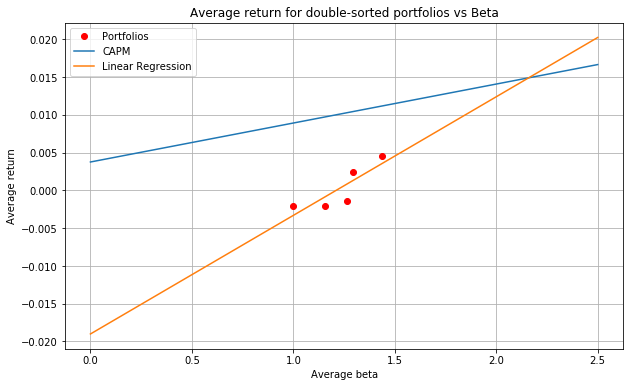

Slope coefficient : 0.01570292652140517
Intercept coefficient : -0.019005230341314714


In [67]:
title = 'Average return for double-sorted portfolios vs Beta'
plot(p_beta,ret,avg_rf,avg_ret_m,title)

In [68]:
stocks_mkt.head()

,date,exchcd,ret,shrout,shrcd,mkt_cap,prc,mrk_cap_lag,dec
permno,,,,,,,,,
10001.0,2009-12-31,2.0,0.162621,4361.0,11.0,44918.300832,10.3000,NaN,NaN
10001.0,2010-01-29,2.0,-0.018932,4361.0,11.0,43871.661830,10.0600,44918.300832,1.0
10001.0,2010-02-26,2.0,-0.000656,4361.0,11.0,43646.632240,10.0084,43871.661830,1.0
10001.0,2010-03-31,2.0,0.020643,4361.0,11.0,44351.370333,10.1700,43646.632240,1.0
10001.0,2010-04-30,2.0,0.124385,6070.0,11.0,69137.302084,11.3900,44351.370333,0.0
